In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [21]:
df = pd.read_excel("AIB_History_Training_2014-2020.xlsx", sheet_name='HistoricalTransactions')

In [22]:
df = df.drop(columns=["FileFolder", "FileName", "Report_Title", "Report_RunDate", "Report_AsOfDate", "Currency", "Institution", "Branch", "TransactionBackdateFlag", "TransactionCode"])
df.head()

,Report_TransactionEffectiveDate,TransactionGroup,TransactionAmount
0,2013-12-30,D,-972.619715
1,2013-12-30,D,-75.956876
2,2013-12-30,C,127.430470
3,2013-12-30,D,-38.300469
4,2013-12-30,D,-117.467137


In [23]:
df.set_index("Report_TransactionEffectiveDate", inplace=True)
df.head()

,TransactionGroup,TransactionAmount
Report_TransactionEffectiveDate,,
2013-12-30,D,-972.619715
2013-12-30,D,-75.956876
2013-12-30,C,127.430470
2013-12-30,D,-38.300469
2013-12-30,D,-117.467137


In [24]:
## Create Debit and Credit df
credit_df = df[df["TransactionGroup"] == "C"].groupby(["Report_TransactionEffectiveDate"])["TransactionAmount"].sum().asfreq('D')
debit_df = df[df["TransactionGroup"] == "D"].groupby(["Report_TransactionEffectiveDate"])["TransactionAmount"].sum().asfreq('D')

## Fill missing values
credit_df = credit_df.fillna(method="ffill").fillna(method="bfill")
debit_df = debit_df.fillna(method="ffill").fillna(method="bfill")

In [25]:
%%time
# Find best sarima params
def find_best_sarima_params(data, seasonal=True, m=7):
    model = auto_arima(data, seasonal=seasonal, m=m, stepwise=True, suppress_warnings=True, trace=False)
    return model.order, model.seasonal_order

credit_order, credit_seasonal= find_best_sarima_params(credit_df)
debit_order, debit_seasonal= find_best_sarima_params(debit_df)
print("Credit Order: ", credit_order)
print("Credit Seasonal: ", credit_seasonal)
print("Debit Order: ", debit_order)
print("Debit Seasonal: ", debit_seasonal)

Credit Order:  (5, 1, 5)
Credit Seasonal:  (2, 0, 2, 7)
Debit Order:  (5, 1, 0)
Debit Seasonal:  (2, 0, 0, 7)
CPU times: total: 9min 37s
Wall time: 10min 31s


In [26]:
def fit_arima_model(data, order, seasonal):
    model = SARIMAX(data, order=order, seasonal=seasonal, enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)
    return results

credit_model_test = fit_arima_model(credit_df, credit_order, credit_seasonal)
debit_model_test = fit_arima_model(debit_df, debit_order, debit_seasonal)

In [27]:
def evaluate_model(model, actual_data, label):
    predicted = model.fittedvalues
    residuals = actual_data - predicted
    mae = mean_absolute_error(actual_data, predicted)
    rmse = np.sqrt(mean_squared_error(actual_data, predicted))
    print(f"{label} Model Evaluation: MAE={mae:.2f}, RMSE={rmse:.2f}")
    
    plt.figure(figsize=(12, 5))
    plt.plot(residuals, label=f'{label} Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Residual Plot for {label} Transactions')
    plt.legend()
    plt.show()
    return mae, rmse
    

Credit Model Evaluation: MAE=12562.21, RMSE=17656.59


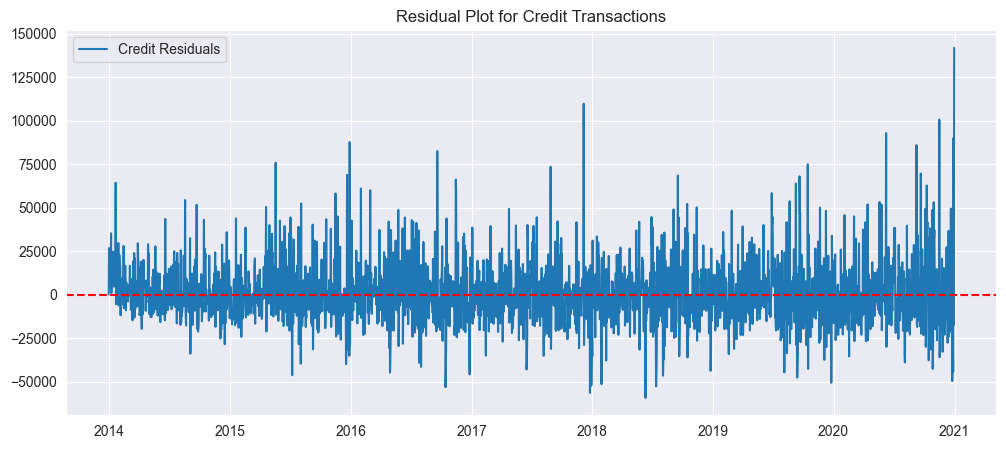

Debit Model Evaluation: MAE=12104.23, RMSE=17435.17


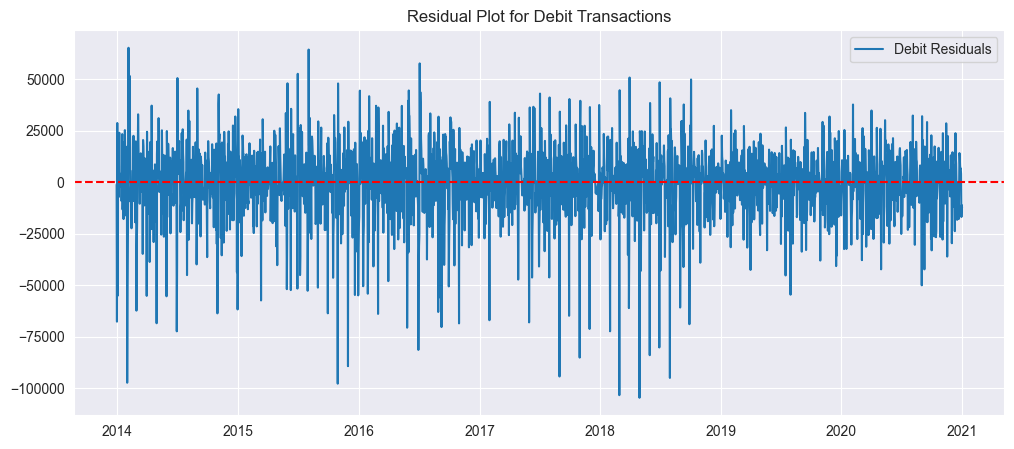

In [28]:
credit_mae, credit_rmse = evaluate_model(credit_model_test, credit_df, "Credit")
debit_mae, debit_rmse = evaluate_model(debit_model_test, debit_df, "Debit")


In [29]:
overall_rmse = (credit_rmse + debit_rmse) / 2
overall_mae = (credit_mae + debit_mae)/2
print(f"Overal Model Evaluation: MAE= {overall_mae}, RMSE={overall_rmse:.2f}")

Overal Model Evaluation: MAE= 12333.220896726201, RMSE=17545.88


In [30]:
## Create model for forecasting
credit_model = fit_arima_model(credit_df, credit_order, credit_seasonal)
debit_model = fit_arima_model(debit_df, debit_order, debit_seasonal)

## Forecast 
forecast_steps = 90
credit_forecast = credit_model.forecast(steps=forecast_steps)
debit_forecast = debit_model.forecast(steps=forecast_steps)

In [31]:
forecast_index = pd.date_range(start=credit_df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecasts_df = pd.DataFrame({
    'credit_forecast': credit_forecast,
    'debit_forecast': debit_forecast,
    'total_forecast': credit_forecast + debit_forecast  # Total transaction forecast
}, index=forecast_index)


In [32]:
# Confidence Intervals
credit_ci = credit_model.get_forecast(steps=forecast_steps).conf_int()
debit_ci = debit_model.get_forecast(steps=forecast_steps).conf_int()
forecasts_df['credit_lower_ci'] = credit_ci.iloc[:, 0]
forecasts_df['credit_upper_ci'] = credit_ci.iloc[:, 1]
forecasts_df['debit_lower_ci'] = debit_ci.iloc[:, 0]
forecasts_df['debit_upper_ci'] = debit_ci.iloc[:, 1]

In [33]:
## Evaluate model
total_actual = credit_df + debit_df
total_actual

Report_TransactionEffectiveDate
2013-12-30     -1076.913729
2013-12-31    -41733.273687
2014-01-01     23416.332059
2014-01-02    -45506.653405
2014-01-03    -18386.381900
                  ...      
2020-12-27    -14363.858907
2020-12-28    -14363.858907
2020-12-29     82156.304473
2020-12-30     22316.790026
2020-12-31    152923.026916
Freq: D, Name: TransactionAmount, Length: 2559, dtype: float64

In [34]:
total_predicted = credit_model.fittedvalues + debit_model.fittedvalues
total_predicted

Report_TransactionEffectiveDate
2013-12-30        0.000000
2013-12-31     -821.496302
2014-01-01   -24502.596404
2014-01-02    -4264.017733
2014-01-03   -28597.150290
                  ...     
2020-12-27     8549.762139
2020-12-28    25727.078961
2020-12-29     8917.113518
2020-12-30    50791.255456
2020-12-31    23327.352701
Freq: D, Length: 2559, dtype: float64

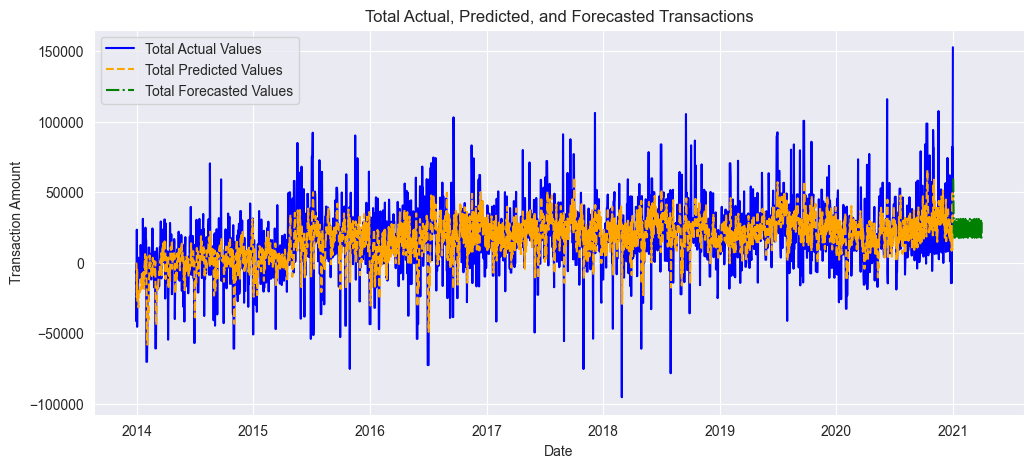

In [35]:
# Plot total actual, predicted, and forecasted values as a line graph
plt.figure(figsize=(12, 5))
plt.plot(total_actual.index, total_actual, label='Total Actual Values', color='blue')
plt.plot(total_predicted.index, total_predicted, label='Total Predicted Values', color='orange', linestyle='--')
plt.plot(forecasts_df.index, forecasts_df['total_forecast'], label='Total Forecasted Values', color='green', linestyle='-.')
plt.title('Total Actual, Predicted, and Forecasted Transactions')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.legend()
plt.show()

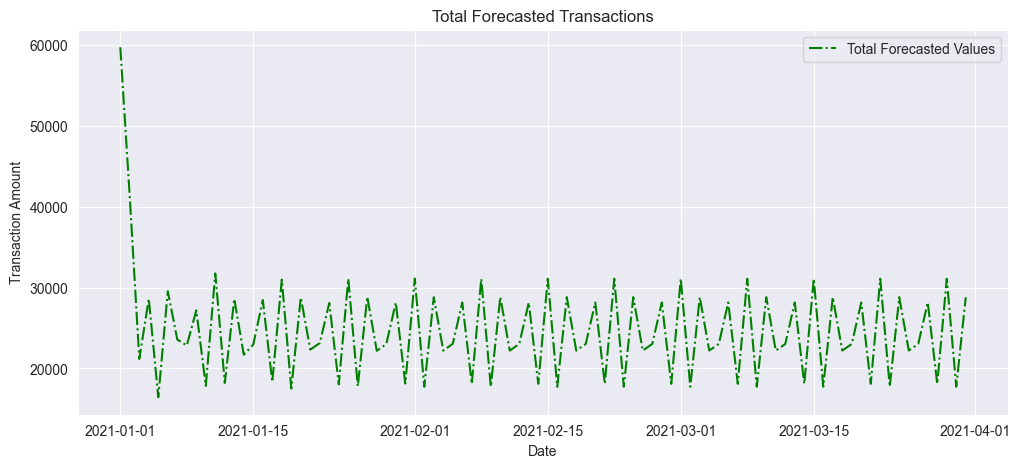

In [36]:
# Plot only the total forecasted values
plt.figure(figsize=(12, 5))
plt.plot(forecasts_df.index, forecasts_df['total_forecast'], label='Total Forecasted Values', color='green', linestyle='-.')
plt.title('Total Forecasted Transactions')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.legend()
plt.show()

In [37]:
forecasts_df

,credit_forecast,debit_forecast,total_forecast,credit_lower_ci,credit_upper_ci,debit_lower_ci,debit_upper_ci
2021-01-01,91615.030736,-31880.776480,59734.254257,55414.719222,127815.342251,-65905.849284,2144.296325
2021-01-02,71566.269215,-30431.844226,41134.424989,33934.436871,109198.101559,-67922.761988,7059.073536
2021-01-03,51269.240749,-30094.406671,21174.834078,13279.675988,89258.805511,-69819.264121,9630.450779
2021-01-04,60772.642436,-32154.880274,28617.762163,22725.641172,98819.643701,-73346.220692,9036.460145
2021-01-05,49214.066654,-32777.274413,16436.792240,11160.210967,87267.922341,-75502.148384,9947.599557
...,...,...,...,...,...,...,...
2021-03-27,60490.589490,-32324.975940,28165.613550,19902.364724,101078.814256,-159652.892024,95002.940145
2021-03-28,50413.152312,-32324.975940,18088.176373,9785.967954,91040.336671,-160347.187030,95697.235151
2021-03-29,63423.417683,-32324.975940,31098.441743,22771.640687,104075.194679,-161037.736963,96387.785084
2021-03-30,50057.738984,-32324.975940,17732.763045,9375.399218,90740.078751,-161724.601782,97074.649903


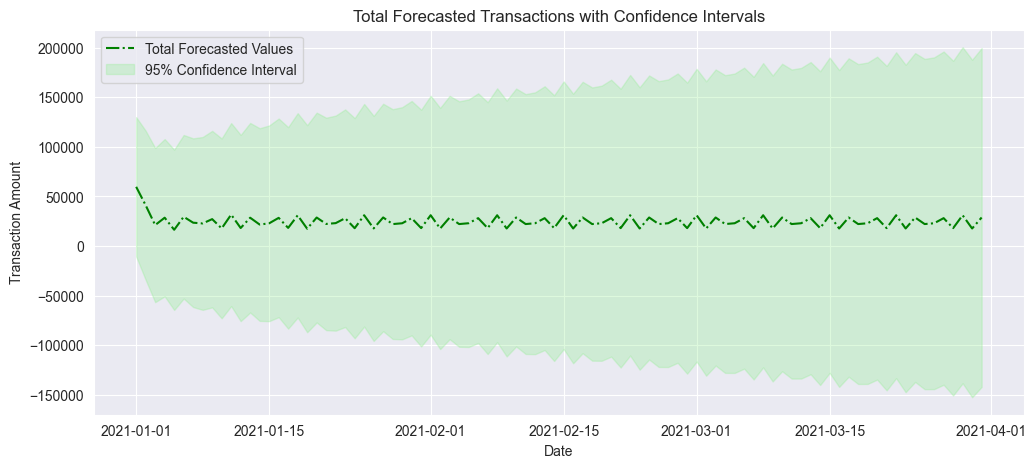

In [38]:
total_lower_ci = forecasts_df['credit_lower_ci'] + forecasts_df['debit_lower_ci']
total_upper_ci = forecasts_df['credit_upper_ci'] + forecasts_df['debit_upper_ci']

# Plot total forecasted values with confidence intervals
plt.figure(figsize=(12, 5))
plt.plot(forecasts_df.index, forecasts_df['total_forecast'], label='Total Forecasted Values', color='green', linestyle='-.')
plt.fill_between(forecasts_df.index, total_lower_ci, total_upper_ci, color='lightgreen', alpha=0.3, label='95% Confidence Interval')
plt.title('Total Forecasted Transactions with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.legend()
plt.show()

In [39]:
forecasts_df

,credit_forecast,debit_forecast,total_forecast,credit_lower_ci,credit_upper_ci,debit_lower_ci,debit_upper_ci
2021-01-01,91615.030736,-31880.776480,59734.254257,55414.719222,127815.342251,-65905.849284,2144.296325
2021-01-02,71566.269215,-30431.844226,41134.424989,33934.436871,109198.101559,-67922.761988,7059.073536
2021-01-03,51269.240749,-30094.406671,21174.834078,13279.675988,89258.805511,-69819.264121,9630.450779
2021-01-04,60772.642436,-32154.880274,28617.762163,22725.641172,98819.643701,-73346.220692,9036.460145
2021-01-05,49214.066654,-32777.274413,16436.792240,11160.210967,87267.922341,-75502.148384,9947.599557
...,...,...,...,...,...,...,...
2021-03-27,60490.589490,-32324.975940,28165.613550,19902.364724,101078.814256,-159652.892024,95002.940145
2021-03-28,50413.152312,-32324.975940,18088.176373,9785.967954,91040.336671,-160347.187030,95697.235151
2021-03-29,63423.417683,-32324.975940,31098.441743,22771.640687,104075.194679,-161037.736963,96387.785084
2021-03-30,50057.738984,-32324.975940,17732.763045,9375.399218,90740.078751,-161724.601782,97074.649903


In [40]:
export_df = pd.DataFrame({
    'GroupName': 'Precision Analyst',
    'Date': forecasts_df.index.dt.date,
    'TotalPredictedAmount': forecasts_df['total_forecast'],
})

# Round the predicted amounts to 2 decimal places
export_df['TotalPredictedAmount'] = export_df['TotalPredictedAmount'].round(2)

# Export to Excel
export_df.to_excel('forecast_results_seasonal_arima.xlsx', index=False)

# Display the first few rows of the exported data
print("Preview of exported data:")
print(export_df.head())

Preview of exported data:
                    GroupName       Date  TotalPredictedAmount
2021-01-01  Precision Analyst 2021-01-01              59734.25
2021-01-02  Precision Analyst 2021-01-02              41134.42
2021-01-03  Precision Analyst 2021-01-03              21174.83
2021-01-04  Precision Analyst 2021-01-04              28617.76
2021-01-05  Precision Analyst 2021-01-05              16436.79
